# Saliency Center Detection CNN Training

This notebook trains a Convolutional Neural Network (CNN) to predict the center coordinates of salient objects in images.

**Dataset:**
- **Input**: 256×256 normalized RGB images from `data/rgb_normalized/`
- **Output**: (un, vn) coordinates from `data/weighted_centers.json` representing the center of salient objects

**Model Goal:**
Train a CNN to regress 2D coordinates (x, y) where salient objects are centered in the image.

In [27]:
# Import Required Libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

# Deep Learning Framework
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, optimizers, callbacks
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
except ImportError:
    print("[Setup] Installing TensorFlow...")
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'tensorflow'])
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, optimizers, callbacks
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set device and configure GPU
print(f"TensorFlow version: {tf.__version__}")
if tf.config.list_physical_devices('GPU'):
    print("GPU available - TensorFlow will use GPU")
    # Enable memory growth to prevent allocation of all GPU memory
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("Using CPU")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

TensorFlow version: 2.20.0
Using CPU


In [ ]:
# Constants and Configuration
from pathlib import Path

# Get the directory where this notebook is located
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"
RGB_DIR = DATA_DIR / "rgb_normalized"
CENTERS_JSON = DATA_DIR / "weighted_centers.json"

# Optional: limit dataset to N images (set to None to use all)
SELECT_N_IMAGES = None  # e.g., 500 or None

# Training parameters
# Default batch size
DEFAULT_BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# Image parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Derive batch size from SELECT_N_IMAGES when provided
if SELECT_N_IMAGES is not None:
    BATCH_SIZE = max(1, SELECT_N_IMAGES // 2)
else:
    BATCH_SIZE = DEFAULT_BATCH_SIZE

print(f"Data directory: {DATA_DIR}")
print(f"RGB images: {RGB_DIR}")
print(f"Centers JSON: {CENTERS_JSON}")
print(f"Target image size: {IMG_WIDTH}×{IMG_HEIGHT}")
print(f"SELECT_N_IMAGES: {SELECT_N_IMAGES}")
print(f"BATCH_SIZE: {BATCH_SIZE}")

Data directory: c:\repos\project\data
RGB images: c:\repos\project\data\rgb_normalized
Centers JSON: c:\repos\project\data\weighted_centers.json
Target image size: 256×256
SELECT_N_IMAGES: 50
BATCH_SIZE: 25


In [38]:
# Load Center Coordinates from JSON
def load_center_coordinates(json_path):
    """Load center coordinates from the weighted_centers.json file"""
    with open(json_path, 'r') as f:
        data = json.load(f)

    coordinates = {}
    for filename, coords in data.items():
        # Extract normalized coordinates (un, vn)
        un = float(coords['un'])
        vn = float(coords['vn'])
        coordinates[filename] = [un, vn]

    return coordinates

# Load the coordinates
print("Loading center coordinates...")
centers_data = load_center_coordinates(CENTERS_JSON)
print(f"Loaded coordinates for {len(centers_data)} images")

# Show sample data
sample_files = list(centers_data.keys())[:5]
print("\nSample coordinates:")
for filename in sample_files:
    un, vn = centers_data[filename]
    print(f"  {filename}: (un={un:.4f}, vn={vn:.4f})")

Loading center coordinates...
Loaded coordinates for 1000 images

Sample coordinates:
  00000.png: (un=0.4063, vn=0.4889)
  00001.png: (un=0.4958, vn=0.5380)
  00002.png: (un=0.2267, vn=0.4702)
  00003.png: (un=0.3748, vn=0.4803)
  00004.png: (un=0.4073, vn=0.5319)


In [30]:
# Create Custom Data Loading Functions
def load_image(image_path):
    """Load and preprocess a single image"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    # Images are already normalized from rgb_normalized folder - no additional normalization needed
    return image

def create_dataset(image_paths, coordinates, batch_size, shuffle=False):
    """Create a TensorFlow dataset from image paths and coordinates"""
    # Convert to tensors
    coordinates_tensor = tf.constant(coordinates, dtype=tf.float32)

    # Create dataset from file paths and coordinates
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, coordinates_tensor))

    # Map the loading function
    dataset = dataset.map(
        lambda path, coord: (load_image(path), coord),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

print("TensorFlow data loading functions created successfully!")

TensorFlow data loading functions created successfully!


In [39]:
# Prepare Train/Validation/Test Split and Create Datasets
def split_data(filenames, train_split=0.8, val_split=0.1, test_split=0.1):
    """Split data into train/val/test sets"""
    assert abs(train_split + val_split + test_split - 1.0) < 1e-6, "Splits must sum to 1.0"

    # Shuffle filenames
    filenames_shuffled = filenames.copy()
    random.shuffle(filenames_shuffled)

    n_total = len(filenames_shuffled)
    n_train = int(n_total * train_split)
    n_val = int(n_total * val_split)

    train_files = filenames_shuffled[:n_train]
    val_files = filenames_shuffled[n_train:n_train + n_val]
    test_files = filenames_shuffled[n_train + n_val:]

    return train_files, val_files, test_files

# Get all available filenames
all_files = list(centers_data.keys())
print(f"Total available files: {len(all_files)}")

# Optionally limit to N images
if SELECT_N_IMAGES is not None:
    # Shuffle before selecting to avoid bias
    shuffled = all_files.copy()
    random.shuffle(shuffled)
    selected_n = min(SELECT_N_IMAGES, len(shuffled))
    all_files = shuffled[:selected_n]
    print(f"Using subset: {selected_n} images")

# Split data
train_files, val_files, test_files = split_data(all_files, TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT)

print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Prepare data for TensorFlow
def prepare_data_for_tf(files, centers_data, image_dir):
    """Prepare file paths and coordinates for TensorFlow dataset"""
    image_paths = [str(Path(image_dir) / filename) for filename in files]
    coordinates = [centers_data[filename] for filename in files]
    return image_paths, coordinates

train_paths, train_coords = prepare_data_for_tf(train_files, centers_data, RGB_DIR)
val_paths, val_coords = prepare_data_for_tf(val_files, centers_data, RGB_DIR)
test_paths, test_coords = prepare_data_for_tf(test_files, centers_data, RGB_DIR)

# Create TensorFlow datasets
train_dataset = create_dataset(train_paths, train_coords, BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(val_paths, val_coords, BATCH_SIZE, shuffle=False)
test_dataset = create_dataset(test_paths, test_coords, BATCH_SIZE, shuffle=False)

print(f"TensorFlow datasets created with batch size: {BATCH_SIZE}")

Total available files: 1000
Using subset: 50 images
Training files: 40
Validation files: 5
Test files: 5
TensorFlow datasets created with batch size: 25


Sample batch shape:
  Images: (25, 256, 256, 3)
  Coordinates: (25, 2)
  Image dtype: <dtype: 'float32'>
  Coordinates dtype: <dtype: 'float32'>

Sample coordinates (first 3):
  Sample 1: (un=0.4664, vn=0.6306)
  Sample 2: (un=0.5073, vn=0.5583)
  Sample 3: (un=0.4175, vn=0.4865)


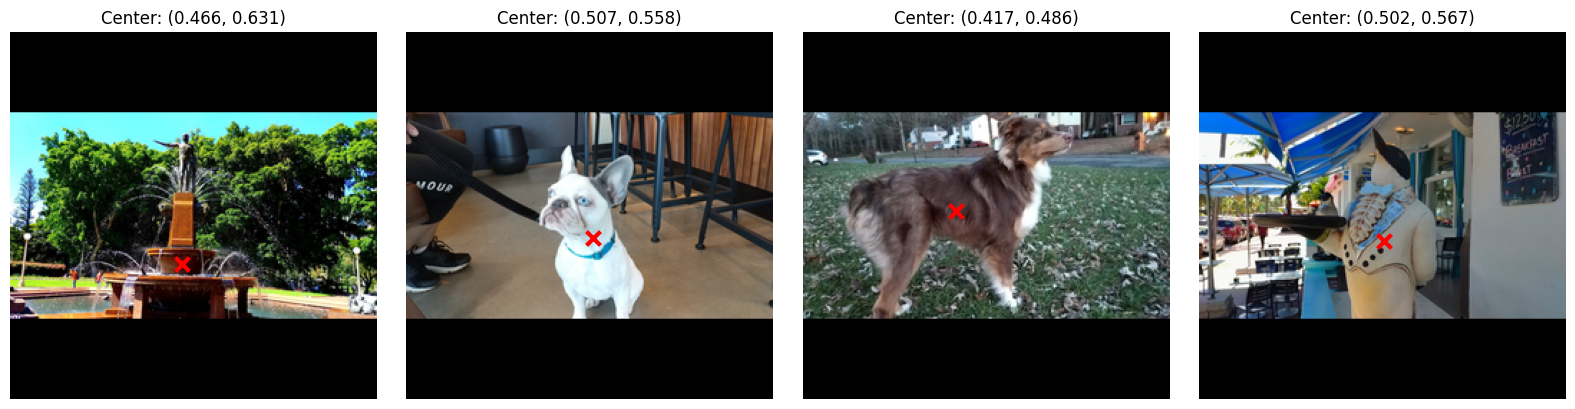

In [40]:
# Test data loading
sample_batch = next(iter(train_dataset))
images, coordinates = sample_batch

print(f"Sample batch shape:")
print(f"  Images: {images.shape}")  # Should be [batch_size, 256, 256, 3]
print(f"  Coordinates: {coordinates.shape}")  # Should be [batch_size, 2]
print(f"  Image dtype: {images.dtype}")
print(f"  Coordinates dtype: {coordinates.dtype}")

print(f"\nSample coordinates (first 3):")
for i in range(min(3, len(coordinates))):
    un, vn = coordinates[i]
    print(f"  Sample {i+1}: (un={un:.4f}, vn={vn:.4f})")

# Visualize a few samples
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(min(4, len(images))):
    # Images are already normalized, just need to ensure they're in [0,1] range
    img = images[i].numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in valid range for display

    axes[i].imshow(img)
    un, vn = coordinates[i]
    # Convert normalized coordinates to pixel coordinates for plotting
    x_pixel = un * IMG_WIDTH
    y_pixel = vn * IMG_HEIGHT
    axes[i].scatter(x_pixel, y_pixel, color='red', s=100, marker='x', linewidths=3)
    axes[i].set_title(f'Center: ({un:.3f}, {vn:.3f})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [33]:
# CNN for detecting the "saliency center" pixel of an image.
# It should return the uv coordinates of the center of the most salient object in the image.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Build CNN Architecture using TensorFlow/Keras
def create_saliency_cnn():
    """Create CNN model for predicting saliency center coordinates"""
    model = Sequential([
        # Input: 256×256×3 (RGB )
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),

        # Convolutional blocks - extract features
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # 128×128

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # 64×64

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # 32×32

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # 16×16

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),

        # Output: 2 values (u, v coordinates) constrained to range [0, 1] in u and v
        Dense(2, activation='sigmoid')
    ])

    # Compile for regression
    model.compile(
        optimizer='adam',
        loss='mse',  # Mean Squared Error for coordinate prediction
        metrics=['mae']  # Mean Absolute Error for monitoring
    )

    return model

    # model = models.Sequential([
    #     # Input layer
    #     layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),

    #     # Convolutional layers with batch normalization
    #     layers.Conv2D(32, 3, padding='same'),
    #     layers.BatchNormalization(),
    #     layers.ReLU(),
    #     layers.MaxPooling2D(2),  # 256→128

    #     layers.Conv2D(64, 3, padding='same'),
    #     layers.BatchNormalization(),
    #     layers.ReLU(),
    #     layers.MaxPooling2D(2),  # 128→64

    #     layers.Conv2D(128, 3, padding='same'),
    #     layers.BatchNormalization(),
    #     layers.ReLU(),
    #     layers.MaxPooling2D(2),  # 64→32

    #     layers.Conv2D(256, 3, padding='same'),
    #     layers.BatchNormalization(),
    #     layers.ReLU(),
    #     layers.MaxPooling2D(2),  # 32→16

    #     layers.Conv2D(256, 3, padding='same'),
    #     layers.BatchNormalization(),
    #     layers.ReLU(),
    #     layers.MaxPooling2D(2),  # 16→8

    #     # Flatten and fully connected layers
    #     layers.Flatten(),
    #     layers.Dense(1024, activation='relu'),
    #     layers.Dropout(0.5),
    #     layers.Dense(512, activation='relu'),
    #     layers.Dropout(0.5),
    #     layers.Dense(128, activation='relu'),
    #     # Use sigmoid but with proper initialization
    #     layers.Dense(2, activation='sigmoid',
    #                 kernel_initializer='glorot_uniform',
    #                 bias_initializer=tf.constant_initializer(-2.0))  # Initialize bias to push sigmoid to center
    # ])

    #return model

# Create model instance
model = create_saliency_cnn()

# Print model summary
model.summary()

print(f"Model created with {model.count_params():,} trainable parameters")

# Test forward pass
test_input = tf.random.normal((1, 256, 256, 3))
test_output = model(test_input)
print(f"Test output shape: {test_output.shape}")
print(f"Test output: {test_output}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,859,042 (132.98 MB)

 Trainable params: 34,859,042 (132.98 MB)

 Non-trainable params: 0 (0.00 B)

Model created with 34,859,042 trainable parameters
Test output shape: (1, 2)
Test output: [[0.48289755 0.4960591 ]]


In [44]:
# Test the updated model on a small batch to see if predictions are reasonable
test_batch = next(iter(train_dataset))
test_images, test_targets = test_batch

# Get a small subset for testing
test_images_small = test_images[:4]
test_targets_small = test_targets[:4]

print("Testing model predictions before training:")
print(f"Target coordinates (first 4 samples):")
for i, (un, vn) in enumerate(test_targets_small):
    print(f"  Sample {i+1}: (un={un:.4f}, vn={vn:.4f})")

# Test model predictions (before training)
predictions = model(test_images_small, training=False)

print(f"\nModel predictions (before training - should be around 0.1-0.2 due to bias init):")
for i, (un, vn) in enumerate(predictions):
    print(f"  Sample {i+1}: (un={un:.4f}, vn={vn:.4f})")

# Check if predictions are reasonable (not 0,0 or 1,1)
pred_mean = tf.reduce_mean(predictions)
print(f"\nMean prediction: {pred_mean:.4f}")
print(f"Prediction std: {tf.math.reduce_std(predictions):.4f}")

if pred_mean < 0.05:
    print("⚠️  Predictions too low - model might have initialization issues")
elif pred_mean > 0.95:
    print("⚠️  Predictions too high - sigmoid might be saturating")
else:
    print("✅ Predictions look reasonable for initial random weights")

print(f"\nModel is ready for training!")

Testing model predictions before training:
Target coordinates (first 4 samples):
  Sample 1: (un=0.4824, vn=0.5425)
  Sample 2: (un=0.4534, vn=0.5742)
  Sample 3: (un=0.4928, vn=0.4751)
  Sample 4: (un=0.4737, vn=0.5390)

Model predictions (before training - should be around 0.1-0.2 due to bias init):
  Sample 1: (un=0.4884, vn=0.5342)
  Sample 2: (un=0.4884, vn=0.5342)
  Sample 3: (un=0.4884, vn=0.5342)
  Sample 4: (un=0.4884, vn=0.5342)

Mean prediction: 0.5113
Prediction std: 0.0229
✅ Predictions look reasonable for initial random weights

Model is ready for training!


In [45]:
# Define Loss Function, Optimizer, and Metrics
# Use regular MSE loss since we're back to sigmoid activation
def euclidean_distance_metric(y_true, y_pred):
    """Calculate mean Euclidean distance between predicted and target coordinates"""
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=1)))

# Increase learning rate slightly for sigmoid
LEARNING_RATE = 0.0005  # Moderate learning rate

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=[euclidean_distance_metric]
)

# Live training curves callback
class TrainingPlotCallback(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []
        self.train_dist = []
        self.val_dist = []
        self.fig = None
        self.axes = None

    def on_train_begin(self, logs=None):
        self.fig, self.axes = plt.subplots(1, 2, figsize=(15, 5))
        plt.tight_layout()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_dist.append(logs.get('euclidean_distance_metric'))
        self.val_dist.append(logs.get('val_euclidean_distance_metric'))

        from IPython.display import clear_output, display
        clear_output(wait=True)
        self.axes[0].cla()
        self.axes[1].cla()

        epochs_range = range(1, len(self.train_loss) + 1)
        # Loss plot
        self.axes[0].plot(epochs_range, self.train_loss, 'b-', label='Training Loss')
        if any(v is not None for v in self.val_loss):
            self.axes[0].plot(epochs_range, self.val_loss, 'r-', label='Validation Loss')
        self.axes[0].set_title('Training and Validation Loss (MSE)')
        self.axes[0].set_xlabel('Epochs')
        self.axes[0].set_ylabel('MSE Loss')
        self.axes[0].legend()
        self.axes[0].grid(True)

        # Distance plot
        self.axes[1].plot(epochs_range, self.train_dist, 'b-', label='Training Distance')
        if any(v is not None for v in self.val_dist):
            self.axes[1].plot(epochs_range, self.val_dist, 'r-', label='Validation Distance')
        self.axes[1].set_title('Training and Validation Distance Error')
        self.axes[1].set_xlabel('Epochs')
        self.axes[1].set_ylabel('Euclidean Distance')
        self.axes[1].legend()
        self.axes[1].grid(True)

        display(self.fig)

# Live predictions visualization callback
class PredictionSamplesCallback(callbacks.Callback):
    def __init__(self, dataset, num_samples=8):
        super().__init__()
        self.dataset = dataset
        self.num_samples = num_samples
        self.fig = None
        self.axes = None
        self.images = None
        self.targets = None

    def on_train_begin(self, logs=None):
        for images, targets in self.dataset:
            self.images = images
            self.targets = targets
            break
        cols = 4
        rows = (min(self.num_samples, len(self.images)) + cols - 1) // cols
        self.fig, self.axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
        if rows == 1:
            self.axes = self.axes.reshape(1, -1)

    def on_epoch_end(self, epoch, logs=None):
        if self.images is None:
            return
        predictions = self.model(self.images, training=False).numpy()
        images_np = np.clip(self.images.numpy(), 0, 1)
        targets_np = self.targets.numpy()
        preds_np = predictions
        num_samples = min(self.num_samples, len(images_np))
        cols = 4
        from IPython.display import display
        # Clear subplots
        for ax in self.fig.axes:
            ax.cla()
        for i in range(num_samples):
            row = i // cols
            col = i % cols
            img = images_np[i]
            target_un, target_vn = targets_np[i]
            pred_un, pred_vn = preds_np[i]
            target_x, target_y = target_un * IMG_WIDTH, target_vn * IMG_HEIGHT
            pred_x, pred_y = pred_un * IMG_WIDTH, pred_vn * IMG_HEIGHT
            pixel_error = np.sqrt((target_x - pred_x)**2 + (target_y - pred_y)**2)
            ax = self.axes[row, col]
            ax.imshow(img)
            ax.scatter(target_x, target_y, color='green', s=100, marker='o', label='GT', alpha=0.8)
            ax.scatter(pred_x, pred_y, color='red', s=100, marker='x', linewidths=3, label='Pred')
            ax.set_title(f'Epoch {epoch+1} | Err: {pixel_error:.1f} px')
            ax.legend()
            ax.axis('off')
        # Hide unused
        rows = self.axes.shape[0]
        cols = self.axes.shape[1]
        for i in range(num_samples, rows * cols):
            row = i // cols
            col = i % cols
            self.axes[row, col].axis('off')
        display(self.fig)

# Define callbacks
training_plot_cb = TrainingPlotCallback()
prediction_samples_cb = PredictionSamplesCallback(test_dataset, num_samples=8)
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,  # Increased patience
        verbose=1,
        min_lr=1e-8
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    training_plot_cb,
    prediction_samples_cb
]

print("Model compiled with:")
print(f"  Loss: MSE")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Metrics: Euclidean Distance")
print(f"  Callbacks: ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TrainingPlotCallback, PredictionSamplesCallback")

Model compiled with:
  Loss: MSE
  Optimizer: Adam (lr=0.0005)
  Metrics: Euclidean Distance
  Callbacks: ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TrainingPlotCallback, PredictionSamplesCallback


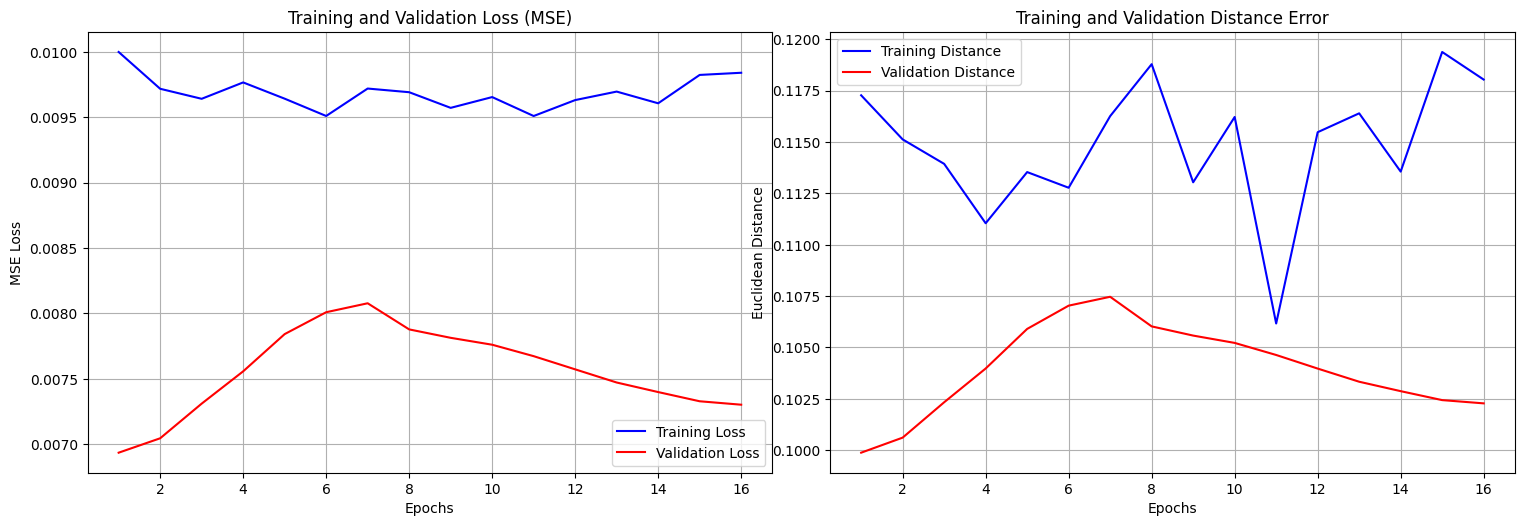

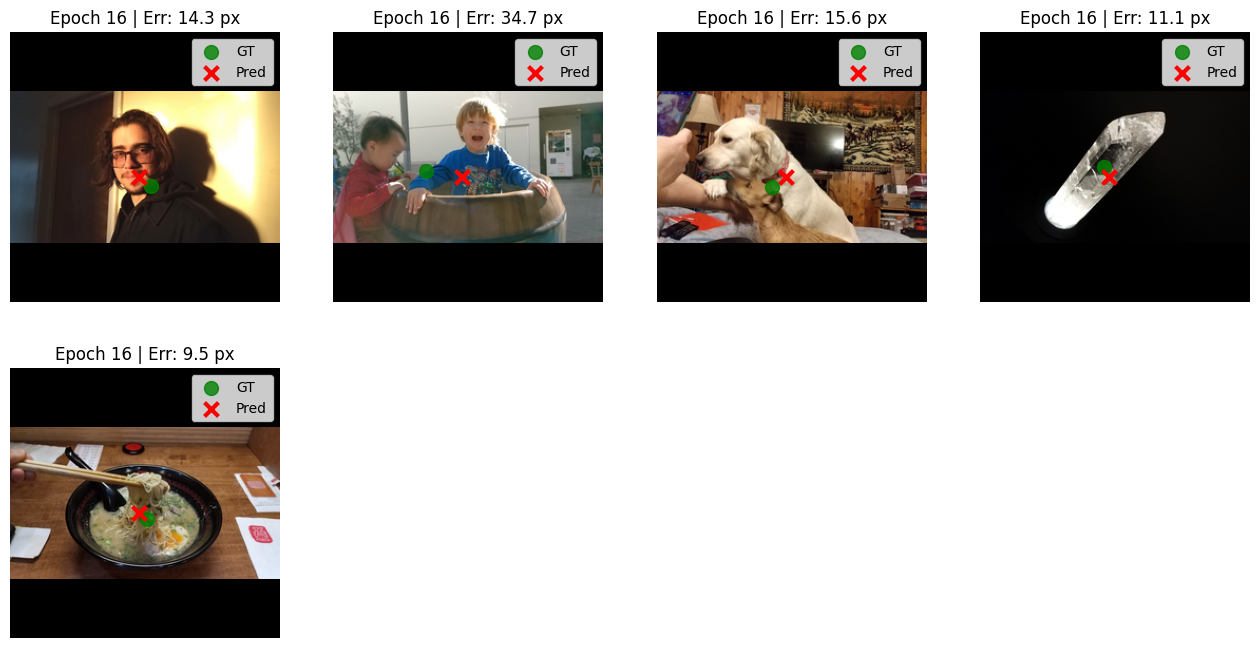

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - euclidean_distance_metric: 0.1180 - loss: 0.0098 - val_euclidean_distance_metric: 0.1023 - val_loss: 0.0073 - learning_rate: 1.2500e-04
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 1.
Training completed!


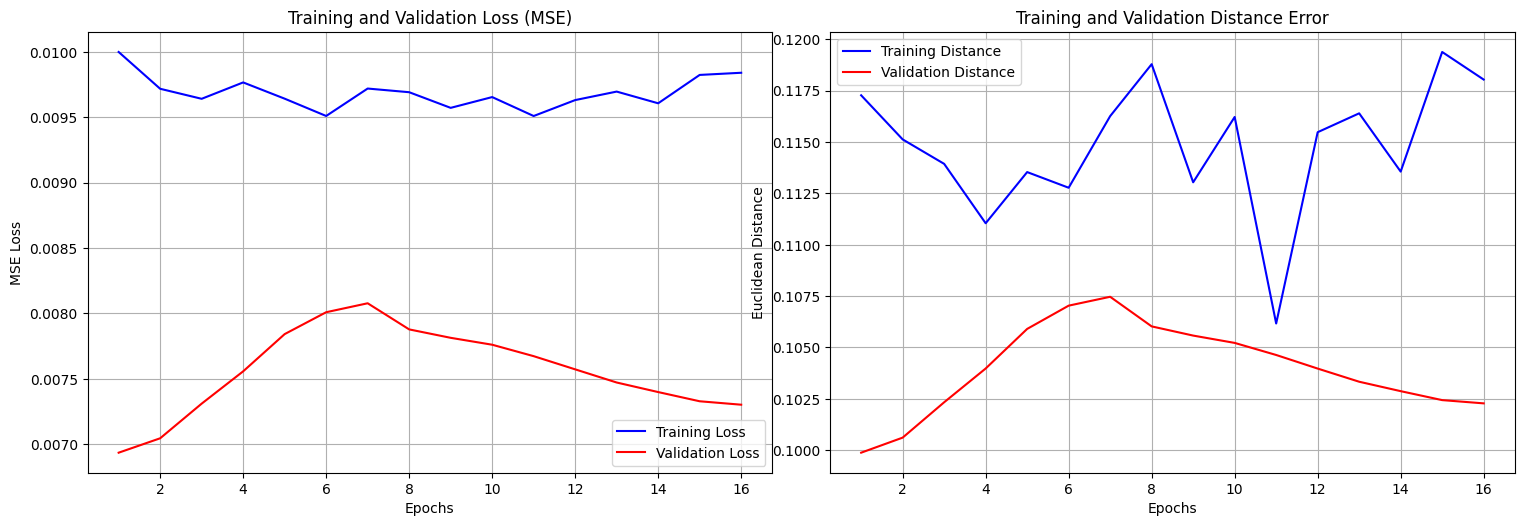

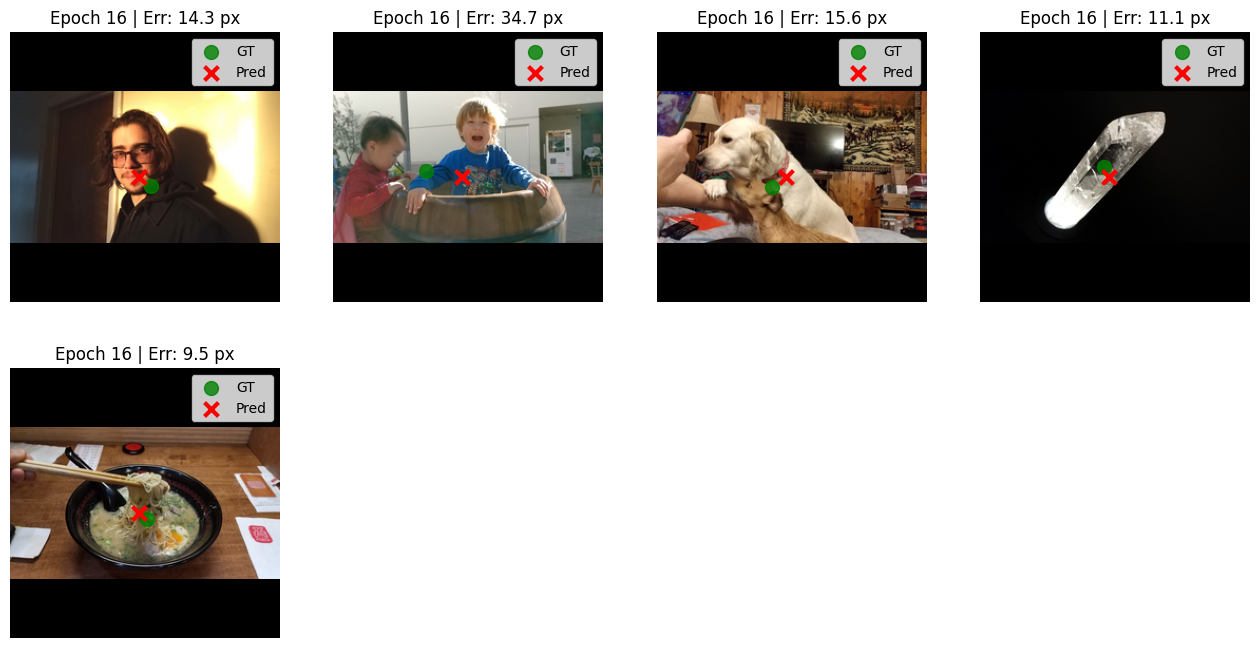

In [46]:
# Implement Training Loop using TensorFlow
print("Starting training...")
print(f"Training for {NUM_EPOCHS} epochs")

# Train the model
history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    verbose=1
)

print("Training completed!")

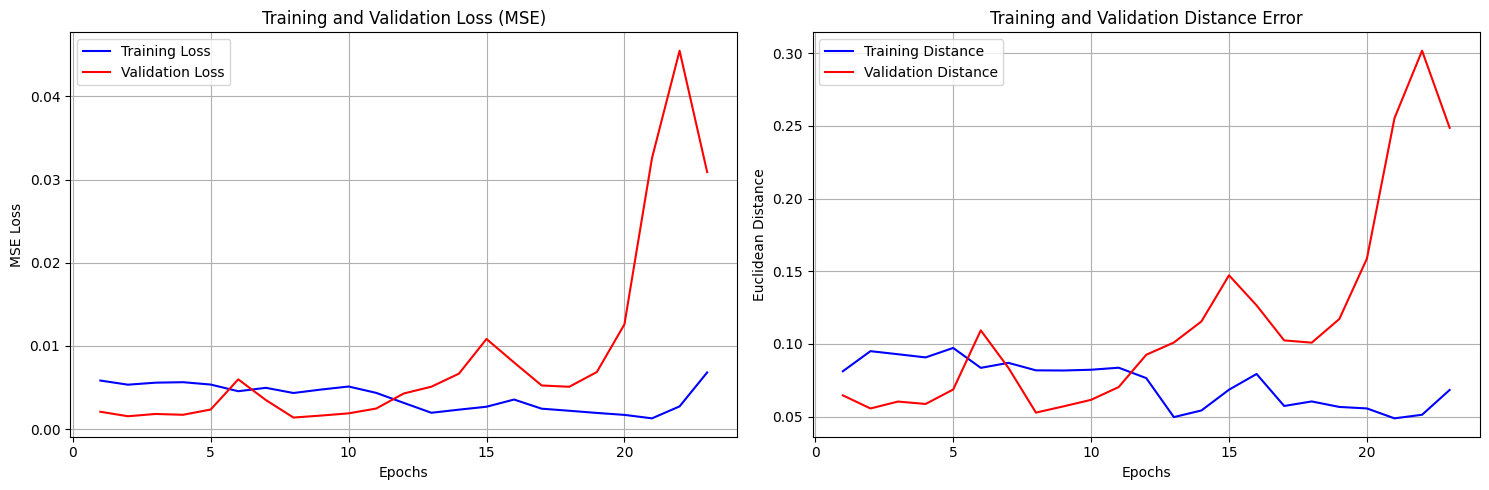


Final Training Metrics:
  Train Loss: 0.006814
  Train Distance: 0.068428
  Val Loss: 0.030899
  Val Distance: 0.248594
  Best Val Loss: 0.001396


In [ ]:
# Plot Training Curves (final summary)
# The live curves are shown during training via TrainingPlotCallback.
# This cell produces a final static summary after training completes.
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
epochs_range = range(1, len(history.history['loss']) + 1)
axes[0].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss')
axes[0].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss')
axes[0].set_title('Training and Validation Loss (MSE)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Euclidean Distance
axes[1].plot(epochs_range, history.history['euclidean_distance_metric'], 'b-', label='Training Distance')
axes[1].plot(epochs_range, history.history['val_euclidean_distance_metric'], 'r-', label='Validation Distance')
axes[1].set_title('Training and Validation Distance Error')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Euclidean Distance')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Metrics:")
print(f"  Train Loss: {history.history['loss'][-1]:.6f}")
print(f"  Train Distance: {history.history['euclidean_distance_metric'][-1]:.6f}")
print(f"  Val Loss: {history.history['val_loss'][-1]:.6f}")
print(f"  Val Distance: {history.history['val_euclidean_distance_metric'][-1]:.6f}")
print(f"  Best Val Loss: {min(history.history['val_loss']):.6f}")

In [ ]:
# Evaluate Model Performance on Test Set
def evaluate_model_tf(model, test_dataset):
    """Evaluate model on test set and return detailed metrics"""
    all_predictions = []
    all_targets = []

    for images, targets in test_dataset:
        predictions = model(images, training=False)
        all_predictions.extend(predictions.numpy())
        all_targets.extend(targets.numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse_loss = np.mean((all_predictions - all_targets) ** 2)
    mae_loss = np.mean(np.abs(all_predictions - all_targets))
    euclidean_distance = np.mean(np.sqrt(np.sum((all_predictions - all_targets) ** 2, axis=1)))

    # Distance in pixels (assuming normalized coordinates)
    pixel_distances = np.sqrt(np.sum((all_predictions - all_targets) ** 2 * np.array([IMG_WIDTH, IMG_HEIGHT]) ** 2, axis=1))
    mean_pixel_distance = np.mean(pixel_distances)
    median_pixel_distance = np.median(pixel_distances)

    return {
        'mse_loss': mse_loss,
        'mae_loss': mae_loss,
        'euclidean_distance': euclidean_distance,
        'mean_pixel_distance': mean_pixel_distance,
        'median_pixel_distance': median_pixel_distance,
        'predictions': all_predictions,
        'targets': all_targets,
        'pixel_distances': pixel_distances
    }

# Evaluate on test set
print("Evaluating model on test set...")
test_results = evaluate_model_tf(model, test_dataset)

print(f"\nTest Set Results:")
print(f"  MSE Loss: {test_results['mse_loss']:.6f}")
print(f"  MAE Loss: {test_results['mae_loss']:.6f}")
print(f"  Euclidean Distance: {test_results['euclidean_distance']:.6f}")
print(f"  Mean Pixel Distance: {test_results['mean_pixel_distance']:.2f} pixels")
print(f"  Median Pixel Distance: {test_results['median_pixel_distance']:.2f} pixels")
print(f"  Max Pixel Distance: {np.max(test_results['pixel_distances']):.2f} pixels")
print(f"  Min Pixel Distance: {np.min(test_results['pixel_distances']):.2f} pixels")

Evaluating model on test set...

Test Set Results:
  MSE Loss: 0.010268
  MAE Loss: 0.090642
  Euclidean Distance: 0.143305
  Mean Pixel Distance: 36.69 pixels
  Median Pixel Distance: 36.69 pixels
  Max Pixel Distance: 36.69 pixels
  Min Pixel Distance: 36.69 pixels


In [ ]:
# Simple Performance Scores
def calculate_simple_scores(test_results):
    """Calculate simple, interpretable performance scores"""

    # Get pixel distances
    pixel_distances = test_results['pixel_distances']
    mean_pixel_error = test_results['mean_pixel_distance']

    # Calculate simple scores (0-100 scale)

    # 1. Accuracy Score: Percentage within 20 pixels (good threshold for 256x256 images)
    accuracy_score = np.mean(pixel_distances <= 20) * 100

    # 2. Precision Score: Based on mean pixel error (lower error = higher score)
    # Max error would be diagonal of image: sqrt(256^2 + 256^2) ≈ 362 pixels
    max_possible_error = np.sqrt(IMG_WIDTH**2 + IMG_HEIGHT**2)
    precision_score = max(0, (1 - mean_pixel_error / max_possible_error) * 100)

    # 3. Consistency Score: Based on standard deviation (lower std = more consistent)
    pixel_std = np.std(pixel_distances)
    consistency_score = max(0, (1 - pixel_std / max_possible_error) * 100)

    # 4. Overall Score: Weighted average
    overall_score = (accuracy_score * 0.4 + precision_score * 0.4 + consistency_score * 0.2)

    return {
        'accuracy_score': accuracy_score,
        'precision_score': precision_score,
        'consistency_score': consistency_score,
        'overall_score': overall_score
    }

def print_simple_scores(test_results):
    """Print simple performance scores in an easy-to-read format"""
    scores = calculate_simple_scores(test_results)

    print("=" * 50)
    print("           SIMPLE PERFORMANCE SCORES")
    print("=" * 50)
    print(f"🎯 Accuracy Score:    {scores['accuracy_score']:.1f}/100")
    print(f"   (% predictions within 20 pixels)")
    print()
    print(f"🔍 Precision Score:   {scores['precision_score']:.1f}/100")
    print(f"   (based on average pixel error)")
    print()
    print(f"📊 Consistency Score: {scores['consistency_score']:.1f}/100")
    print(f"   (how consistent predictions are)")
    print()
    print(f"🏆 OVERALL SCORE:     {scores['overall_score']:.1f}/100")
    print("=" * 50)

    # Interpretation
    overall = scores['overall_score']
    if overall >= 90:
        grade = "A+ (Excellent)"
    elif overall >= 80:
        grade = "A  (Very Good)"
    elif overall >= 70:
        grade = "B  (Good)"
    elif overall >= 60:
        grade = "C  (Fair)"
    elif overall >= 50:
        grade = "D  (Poor)"
    else:
        grade = "F  (Needs Work)"

    print(f"Model Grade: {grade}")
    print()

    # Quick stats
    mean_error = test_results['mean_pixel_distance']
    within_10px = np.mean(test_results['pixel_distances'] <= 10) * 100
    within_30px = np.mean(test_results['pixel_distances'] <= 30) * 100

    print("Quick Stats:")
    print(f"  • Average error: {mean_error:.1f} pixels")
    print(f"  • Within 10 pixels: {within_10px:.1f}%")
    print(f"  • Within 30 pixels: {within_30px:.1f}%")

    return scores

# Calculate and display simple scores
print("Calculating simple performance scores...")
simple_scores = print_simple_scores(test_results)

Calculating simple performance scores...
           SIMPLE PERFORMANCE SCORES
🎯 Accuracy Score:    0.0/100
   (% predictions within 20 pixels)

🔍 Precision Score:   89.9/100
   (based on average pixel error)

📊 Consistency Score: 100.0/100
   (how consistent predictions are)

🏆 OVERALL SCORE:     55.9/100
Model Grade: D  (Poor)

Quick Stats:
  • Average error: 36.7 pixels
  • Within 10 pixels: 0.0%
  • Within 30 pixels: 0.0%


Visualizing model predictions...


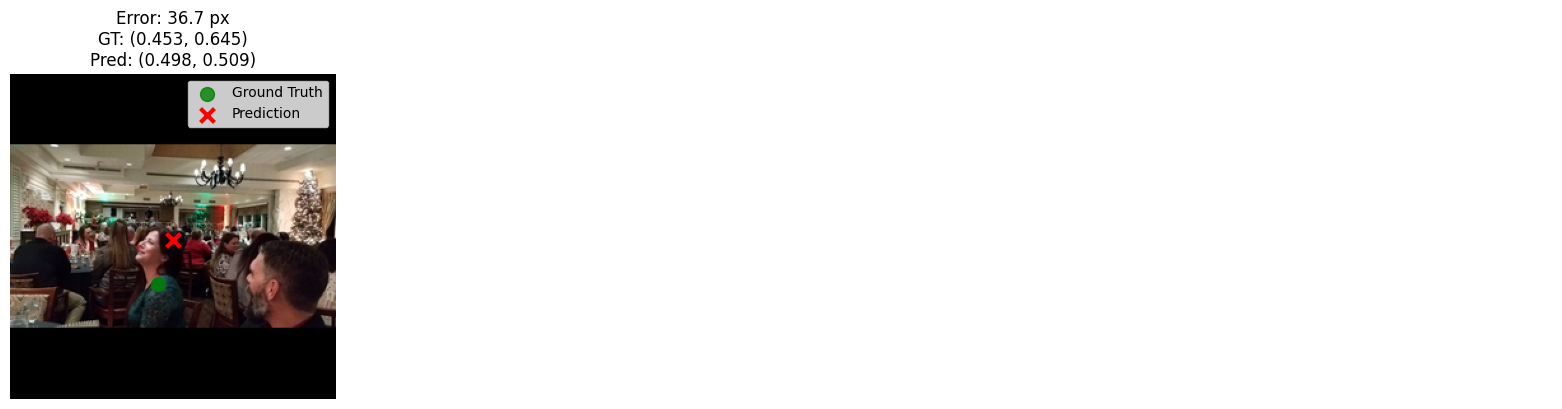

In [ ]:
# Visualize Predictions vs Ground Truth (final snapshot)
# During training, live predictions are displayed by PredictionSamplesCallback.
# This cell produces a static snapshot after training completes.
def visualize_predictions_tf(model, test_dataset, num_samples=8):
    """Visualize model predictions on test samples"""
    # Get a batch of test data
    for images, targets in test_dataset:
        break  # Get first batch

    predictions = model(images, training=False)

    # Convert to numpy
    images_np = images.numpy()
    targets_np = targets.numpy()
    predictions_np = predictions.numpy()

    # Images are already normalized, just ensure they're in [0,1] range for display
    images_np = np.clip(images_np, 0, 1)

    # Plot samples
    num_samples = min(num_samples, len(images))
    cols = 4
    rows = (num_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        row = i // cols
        col = i % cols

        # Get image and coordinates
        img = images_np[i]
        target_un, target_vn = targets_np[i]
        pred_un, pred_vn = predictions_np[i]

        # Convert to pixel coordinates
        target_x, target_y = target_un * IMG_WIDTH, target_vn * IMG_HEIGHT
        pred_x, pred_y = pred_un * IMG_WIDTH, pred_vn * IMG_HEIGHT

        # Calculate distance error
        pixel_error = np.sqrt((target_x - pred_x)**2 + (target_y - pred_y)**2)

        # Plot image
        axes[row, col].imshow(img)
        axes[row, col].scatter(target_x, target_y, color='green', s=100, marker='o',
                              label='Ground Truth', alpha=0.8)
        axes[row, col].scatter(pred_x, pred_y, color='red', s=100, marker='x',
                              linewidths=3, label='Prediction')
        axes[row, col].set_title(f'Error: {pixel_error:.1f} px\nGT: ({target_un:.3f}, {target_vn:.3f})\nPred: ({pred_un:.3f}, {pred_vn:.3f})')
        axes[row, col].legend()
        axes[row, col].axis('off')

    # Hide unused subplots
    for i in range(num_samples, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
print("Visualizing model predictions...")
visualize_predictions_tf(model, test_dataset, num_samples=8)

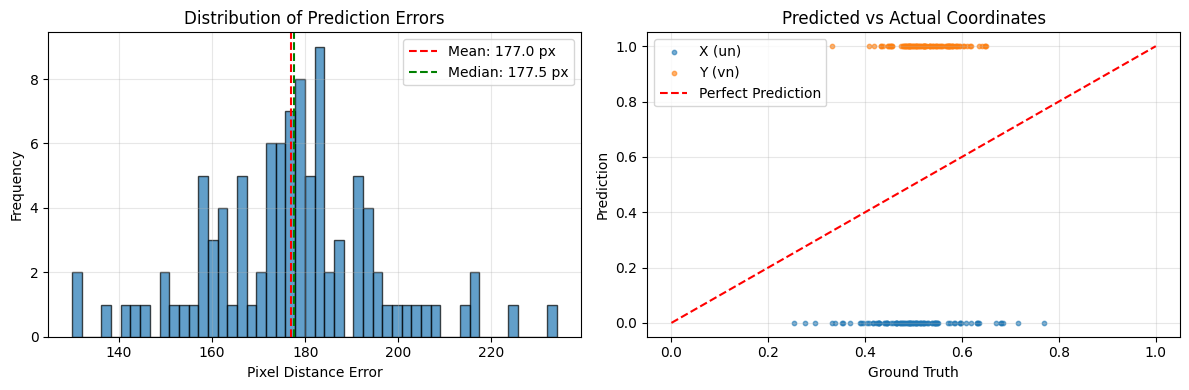


Accuracy at different pixel distance thresholds:
  ≤  5 pixels: 0.0%
  ≤ 10 pixels: 0.0%
  ≤ 15 pixels: 0.0%
  ≤ 20 pixels: 0.0%
  ≤ 25 pixels: 0.0%
  ≤ 30 pixels: 0.0%


In [ ]:
# Plot Error Distribution
plt.figure(figsize=(12, 4))

# Plot histogram of pixel distances
plt.subplot(1, 2, 1)
plt.hist(test_results['pixel_distances'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(test_results['mean_pixel_distance'], color='red', linestyle='--',
           label=f'Mean: {test_results["mean_pixel_distance"]:.1f} px')
plt.axvline(test_results['median_pixel_distance'], color='green', linestyle='--',
           label=f'Median: {test_results["median_pixel_distance"]:.1f} px')
plt.xlabel('Pixel Distance Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot: predicted vs actual
plt.subplot(1, 2, 2)
predictions = test_results['predictions']
targets = test_results['targets']

plt.scatter(targets[:, 0], predictions[:, 0], alpha=0.6, label='X (un)', s=10)
plt.scatter(targets[:, 1], predictions[:, 1], alpha=0.6, label='Y (vn)', s=10)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Predicted vs Actual Coordinates')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate accuracy at different thresholds
thresholds = [5, 10, 15, 20, 25, 30]
print(f"\nAccuracy at different pixel distance thresholds:")
for threshold in thresholds:
    accuracy = np.mean(test_results['pixel_distances'] <= threshold)
    print(f"  ≤ {threshold:2d} pixels: {accuracy*100:.1f}%")

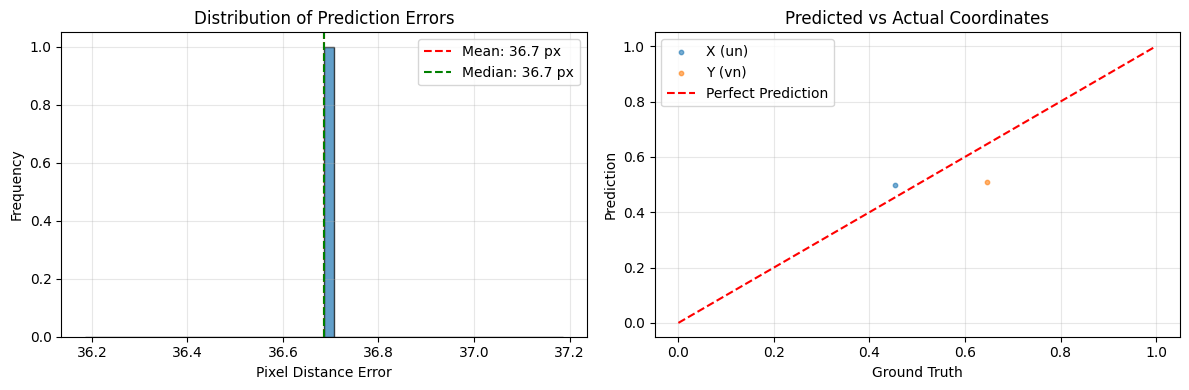


Accuracy at different pixel distance thresholds:
  ≤  5 pixels: 0.0%
  ≤ 10 pixels: 0.0%
  ≤ 15 pixels: 0.0%
  ≤ 20 pixels: 0.0%
  ≤ 25 pixels: 0.0%
  ≤ 30 pixels: 0.0%


In [ ]:
# Plot Error Distribution
plt.figure(figsize=(12, 4))

# Plot histogram of pixel distances
plt.subplot(1, 2, 1)
plt.hist(test_results['pixel_distances'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(test_results['mean_pixel_distance'], color='red', linestyle='--',
           label=f'Mean: {test_results["mean_pixel_distance"]:.1f} px')
plt.axvline(test_results['median_pixel_distance'], color='green', linestyle='--',
           label=f'Median: {test_results["median_pixel_distance"]:.1f} px')
plt.xlabel('Pixel Distance Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot: predicted vs actual
plt.subplot(1, 2, 2)
predictions = test_results['predictions']
targets = test_results['targets']

plt.scatter(targets[:, 0], predictions[:, 0], alpha=0.6, label='X (un)', s=10)
plt.scatter(targets[:, 1], predictions[:, 1], alpha=0.6, label='Y (vn)', s=10)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Predicted vs Actual Coordinates')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate accuracy at different thresholds
thresholds = [5, 10, 15, 20, 25, 30]
print(f"\nAccuracy at different pixel distance thresholds:")
for threshold in thresholds:
    accuracy = np.mean(test_results['pixel_distances'] <= threshold)
    print(f"  ≤ {threshold:2d} pixels: {accuracy*100:.1f}%")

In [ ]:
# Save Trained Model
# Create models directory
models_dir = Path(DATA_DIR) / "models"
models_dir.mkdir(exist_ok=True)

# Save model in TensorFlow format
model_path = models_dir / "saliency_cnn_model.h5"
model.save(model_path)

# Save model in SavedModel format (recommended for production)
saved_model_path = models_dir / "saliency_cnn_saved_model"
model.save(saved_model_path)

# Save training history
history_path = models_dir / "training_history.json"
import json
history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}
with open(history_path, 'w') as f:
    json.dump({
        'history': history_dict,
        'test_results': {
            'mse_loss': float(test_results['mse_loss']),
            'mae_loss': float(test_results['mae_loss']),
            'euclidean_distance': float(test_results['euclidean_distance']),
            'mean_pixel_distance': float(test_results['mean_pixel_distance']),
            'median_pixel_distance': float(test_results['median_pixel_distance'])
        },
        'model_params': {
            'img_width': IMG_WIDTH,
            'img_height': IMG_HEIGHT,
            'img_channels': IMG_CHANNELS,
            'num_epochs': NUM_EPOCHS,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE
        }
    }, f, indent=2)

print(f"Model saved successfully!")
print(f"  Model (.h5): {model_path}")
print(f"  SavedModel: {saved_model_path}")
print(f"  Training history: {history_path}")
print(f"  Best validation loss: {min(history.history['val_loss']):.6f}")

# Create inference example for TensorFlow
inference_example_path = models_dir / "tensorflow_inference_example.py"
inference_example = f'''
# Example of loading and using the trained TensorFlow model for inference

import tensorflow as tf
import numpy as np
from PIL import Image
import json

def load_model(model_path):
    """Load the trained model"""
    model = tf.keras.models.load_model(model_path)
    return model

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess image for prediction"""
    # Load image
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)

    # Convert to array and normalize to [0,1] - no ImageNet normalization needed
    # since the model was trained on images that were already normalized
    image_array = np.array(image) / 255.0

    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)

    return image_array

def predict_center(model, image_path):
    """Predict saliency center for a single image"""
    # Preprocess image
    image_array = preprocess_image(image_path)

    # Predict
    prediction = model.predict(image_array, verbose=0)

    # Extract coordinates
    un, vn = prediction[0]
    return float(un), float(vn)

def predict_center_pixels(model, image_path, target_size=(256, 256)):
    """Predict saliency center and convert to pixel coordinates"""
    un, vn = predict_center(model, image_path)
    x_pixel = un * target_size[0]
    y_pixel = vn * target_size[1]
    return x_pixel, y_pixel, un, vn

# Example usage:
if __name__ == "__main__":
    # Load model
    model = load_model('{model_path}')

    # Predict on an image
    # un, vn = predict_center(model, 'path/to/image.jpg')
    # print(f"Predicted center: ({{un:.4f}}, {{vn:.4f}})")

    # Or get pixel coordinates
    # x, y, un, vn = predict_center_pixels(model, 'path/to/image.jpg')
    # print(f"Predicted center: ({{x:.1f}}, {{y:.1f}}) pixels, ({{un:.4f}}, {{vn:.4f}}) normalized")
'''

with open(inference_example_path, 'w') as f:
    f.write(inference_example)

print(f"  Inference example: {inference_example_path}")
print(f"\nTraining complete! The TensorFlow model is ready for inference.")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=c:\repos\project\data\models\saliency_cnn_saved_model.